# Fashion-Mnist

This is the second notebook for my project, in which I will try to get the best result I can to classify the Fahion-Mnist Data set

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

First lets import the data and see how it looks

In [3]:
df = pd.read_csv("D:\ML_SEM2\\fashion-mnist_train.csv")

In [4]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


After getting the dataset lets split it to the labels and the data itself

In [5]:
labels = df.label.values
labels

array([2, 9, 6, ..., 8, 8, 7], dtype=int64)

In [6]:
data = df.drop(['label'],axis = 1).values
data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

Reshape data to correct dimensions to see how an image looks like

In [7]:
data_to_show = data.reshape(-1,28,28,1)

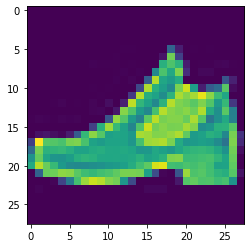

In [29]:
plt.imshow(data_to_show[1]);

lets see how it looks in black and white

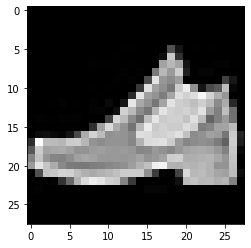

In [42]:
plt.imshow(data_to_show[1],cmap = plt.get_cmap("gray"));

Now lets split the Data and try to get some results from it 

In [45]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
data_train, data_test, target_train, target_test = train_test_split(data, labels,test_size = 0.05, random_state=10)

Lets train 2 calssifiers before reducing the dimensions, KNN classifier and a random forest classifier, and use XGBoost as well

Also I want to see how much time (in seconds) it takes for each classifier os maybe we can get a bit of a worse result but in a much faster time

In [46]:
from sklearn.neighbors import KNeighborsClassifier
import time
knn = KNeighborsClassifier(n_neighbors = 20)

In [47]:
start_time = time.time()
knn.fit(data_train, target_train)
pred = knn.predict(data_test)
train = knn.predict(data_train)
print(metrics.accuracy_score(target_test,pred))
print(metrics.accuracy_score(target_train,train))
print("time to calculate %.2f" %(time.time()-start_time))

0.8496666666666667
0.8599122807017544
time to calculate 4146.54


In [48]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(n_estimators = 100, max_depth = 2)

In [49]:
start_time = time.time()
RFC.fit(data_train, target_train)
pred = RFC.predict(data_test)
train = RFC.predict(data_train)
print(metrics.accuracy_score(target_test,pred))
print(metrics.accuracy_score(target_train,train))
print("time to calculate %.2f" %(time.time()-start_time))

0.571
0.5757719298245614
time to calculate 16.35


In [50]:
import xgboost
xgb = xgboost.XGBClassifier(n_estimators = 100,eval_metric = "merror",learning_rate = 0.5)

In [51]:
start_time = time.time()
xgb.fit(data_train, target_train)
pred = xgb.predict(data_test)
train = xgb.predict(data_train)
print(metrics.accuracy_score(target_test,pred))
print(metrics.accuracy_score(target_train,train))
print("time to calculate %.2f" %(time.time()-start_time))

0.9053333333333333
1.0
time to calculate 445.61


After running the classifiers on the full data, lets wee if we can reduce our dimensions to get a faster result

I will use the PCA and plot the explaind variance ratio to see how much dimensions are needed to explain a precentege of the variance

In [52]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(data_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)

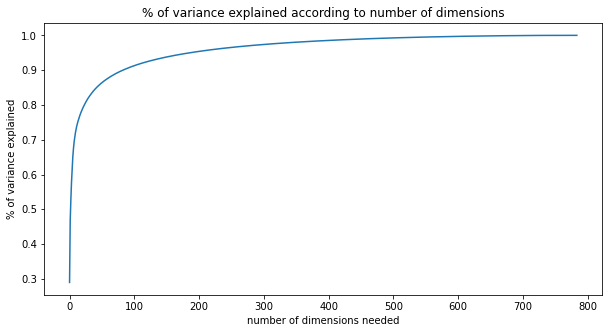

In [53]:
plt.figure(figsize = [10,5])
plt.plot(cumsum)
plt.ylabel("% of variance explained")
plt.xlabel("number of dimensions needed")
plt.title("% of variance explained according to number of dimensions");

lets aim for 95% of the variance

In [54]:
pca = PCA(n_components = 0.95)
data_reduced = pca.fit_transform(data_train)
test_reduced = pca.transform(data_test)
data_recoverd = pca.inverse_transform(data_reduced)
test_recoverd = pca.inverse_transform(test_reduced)

In [55]:
data_reduced.shape

(57000, 187)

As we can see we only need 187 dimensions to explain 95% of the variance

In [56]:
data_recoverd.shape

(57000, 784)

In [57]:
data_recoverd_to_show = data_recoverd.reshape(-1,28,28,1)

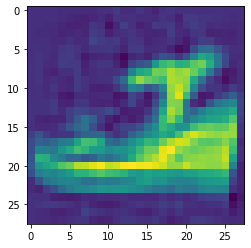

In [58]:
plt.imshow(data_recoverd_to_show[69]);

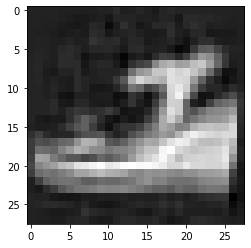

In [59]:
plt.imshow(data_recoverd_to_show[69],cmap = plt.get_cmap("gray"))

Now lets try training on the data after the PCA

In [60]:
start_time = time.time()
knn.fit(data_recoverd, target_train)
pred = knn.predict(test_recoverd)
train = knn.predict(data_recoverd)
print(metrics.accuracy_score(target_test,pred))
print(metrics.accuracy_score(target_train,train))
print("time to calculate %.2f" %(time.time()-start_time))

0.86
0.8683333333333333
time to calculate 3345.76


Lets also use some different variations of XGBoost, increasing the estimators but lowering the learning rate 

In [61]:
xgb = xgboost.XGBClassifier(n_estimators = 100,eval_metric = "merror",learning_rate = 0.5)

In [62]:
start_time = time.time()
xgb.fit(data_recoverd, target_train)
pred = xgb.predict(test_recoverd)
train = xgb.predict(data_recoverd)
print(metrics.accuracy_score(target_test,pred))
print(metrics.accuracy_score(target_train,train))
print("time to calculate %.2f" %(time.time()-start_time))

0.898
1.0
time to calculate 2171.74


In [63]:
start_time = time.time()
xgb = xgboost.XGBClassifier(n_estimators = 150,eval_metric = "merror",learning_rate = 0.25)
xgb.fit(data_recoverd, target_train)
pred = xgb.predict(test_recoverd)
train = xgb.predict(data_recoverd)
print(metrics.accuracy_score(target_test,pred))
print(metrics.accuracy_score(target_train,train))
print("time to calculate %.2f" %(time.time()-start_time))

0.904
1.0
time to calculate 4986.88


In [64]:
start_time = time.time()
xgb = xgboost.XGBClassifier(n_estimators = 200,eval_metric = "merror",learning_rate = 0.1)
xgb.fit(data_recoverd, target_train)
pred = xgb.predict(test_recoverd)
train = xgb.predict(data_recoverd)
print(metrics.accuracy_score(target_test,pred))
print(metrics.accuracy_score(target_train,train))
print("time to calculate %.2f" %(time.time()-start_time))

0.898
0.9937719298245614
time to calculate 5141.24
